# Google TF certification 3
### Time series analysis models comparison.

This is the third of a series of notebooks tha I've elaborated when preparing my [Google TensorFLow developer certificate](https://www.tensorflow.org/certificate?hl=es-419).
The election of a good model architecture is essential and remnains an art, so it is counseled to develop some intuition in order to be successful when applying deep learning.

This notebooks relies heavily con the [Coursera TensorFlow specialization](https://www.coursera.org/professional-certificates/tensorflow-in-practice) and the [Lawrence Moroney's book](https://github.com/lmoroney/tfbook). Some modifications aimed at testing my comprenhension and coding skills have been introduced.

The code in this notebook needs TF verson 2.0 or superior, so we check it.

In [14]:
import time
now_i = time.time()

In [15]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
from sklearn.preprocessing import StandardScaler
import pandas as pd

2.8.0


In [17]:
#First of all we retrieve the data, using the code proposed by Moroney.

In [18]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/station.csv \
    -O /tmp/station.csv

--2022-05-11 12:32:41--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/station.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6979 (6.8K) [application/octet-stream]
Saving to: ‘/tmp/station.csv’

/tmp/station.csv    100%[===================>]   6.82K  --.-KB/s    in 0s      

2022-05-11 12:32:41 (98.7 MB/s) - ‘/tmp/station.csv’ saved [6979/6979]



The following function (get_data()) prepare the data, cleaning it and returning the serie to be studied.

In [19]:
def get_data():
    """
    Esta funcion lee un csv, luego lo abre y toma los datos los pone en una lista
    y luego los convierte en numpy arrays.
    Los datos viene a ser el time, y los labels la temperatura".
    """
    data_file = "/tmp/station.csv"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    header = lines[0].split(',')
    lines = lines[1:]
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(',')
            linedata = linedata[1:13]
            for item in linedata:
                if item:
                    temperatures.append(float(item))

    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")      
    return time, series


In [20]:
time,series = get_data()

It is important to at least eyeball the data in order to understand what are we doing.

In [21]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Esta función simplemente toma los datos y los grafica.
    El tiempo es una simple secuencia de valores.
    """
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


## Data normalization
### It is known that neural networks work better with normalized data.

In [22]:
"""
Aquí lo que hace es normalizar la temperatura.
Para ello resta la media y divide por la std.
Luego separa una parte para ser usada en el training y otra en la validation."""
mean = series.mean(axis=0)
series-=mean
std = series.std(axis=0)
series/=std
split_time = 780
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

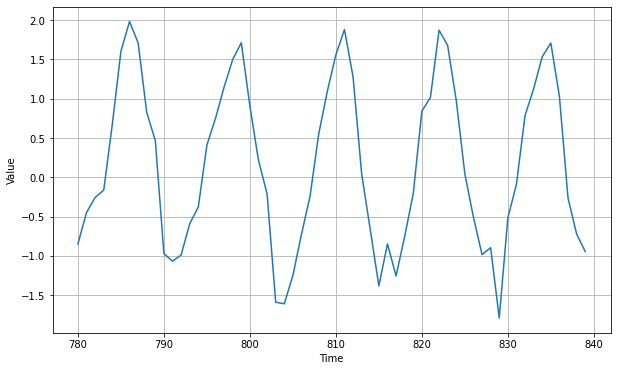

In [23]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

TensorFlow provides the code in order to prepare the data to be ingested by the neural network.
Essentially, it is supervised learning, so it must be organised in terms of inputs and labels. This mechanism is clearly explained by Moroney both in the book and in the course. In case the lector is not familiar with it, I encourage him to read it carefully.

In [24]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """
  Esta función toma las series y usando funciones de tensorflow 
  las transforma en datos prontos para ser ingresados en la neural network.
  """
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [25]:
window_size = 40
batch_size = 20
shuffle_buffer_size = 20

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

# First model applied: Bidirectional GRU

In order to get familiar with the different alternative models, we are going to make some trials.
Note that there are two layers, both of them with both simple and recurrent dropout. Due to the network structure, recurrent networks have a second dropout, called recurrent dropout.





In [46]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
# Experiment with this to play with accuracy. Do note that
# this is a small dataset, so a large window size may
# cause errors.
window_size = 40
batch_size = 20
shuffle_buffer_size = 20

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
import time
now = time.time()
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.1)),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)), 
  tf.keras.layers.Dense(1),
])

#optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.RMSprop(), metrics=["mae"])
history = model.fit(dataset, epochs=30,  verbose=1, validation_data=valid_dataset)
print ("Con optimizer: optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.7)\nEpoch 30/30\n\
       7/37 [==============================] - 16s 422ms/step - loss: 0.3908 - mae: 0.7897 - val_loss: 0.4666 - val_mae: 0.8967")

Epoch 1/30
37/37 [==============================] - 25s 461ms/step - loss: 0.0848 - mae: 0.3177 - val_loss: 0.0665 - val_mae: 0.2908
Epoch 2/30
37/37 [==============================] - 16s 435ms/step - loss: 0.0547 - mae: 0.2636 - val_loss: 0.0426 - val_mae: 0.2275
Epoch 3/30
37/37 [==============================] - 16s 433ms/step - loss: 0.0502 - mae: 0.2491 - val_loss: 0.0488 - val_mae: 0.2483
Epoch 4/30
37/37 [==============================] - 16s 434ms/step - loss: 0.0520 - mae: 0.2552 - val_loss: 0.0499 - val_mae: 0.2510
Epoch 5/30
37/37 [==============================] - 16s 431ms/step - loss: 0.0440 - mae: 0.2373 - val_loss: 0.0479 - val_mae: 0.2475
Epoch 6/30
37/37 [==============================] - 16s 431ms/step - loss: 0.0454 - mae: 0.2396 - val_loss: 0.0573 - val_mae: 0.2671
Epoch 7/30
37/37 [==============================] - 16s 431ms/step - loss: 0.0474 - mae: 0.2414 - val_loss: 0.0677 - val_mae: 0.2906
Epoch 8/30
37/37 [==============================] - 16s 431ms/step - 

In order to inspect the model accuracy, we must use it to predict values. The following functions and graphs allow us to have an idea of what is happening.

In [47]:
def model_forecast(model, series, window_size):
    """
    Esta función toma toda la serie y la pasa al método predict
    del modelo.
    Como resultado tenemos toda la serie predicha por el modelo.
    """
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [48]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

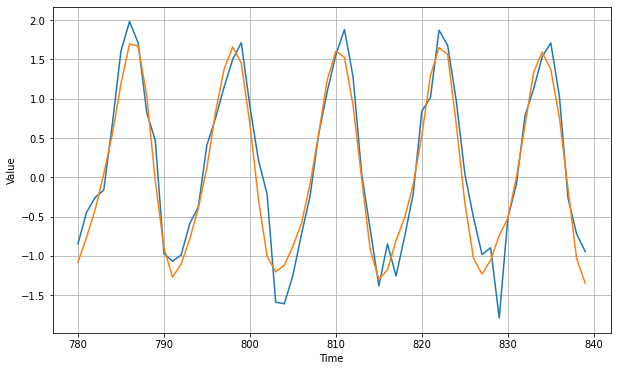

In [49]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()



In [50]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(mae)
print (f"Ajustar y evaluar este modelo demoró {round((time.time()-now)/60,2)} minutos.")

0.25258416
Ajustar y evaluar este modelo demoró 11.26 minutos.


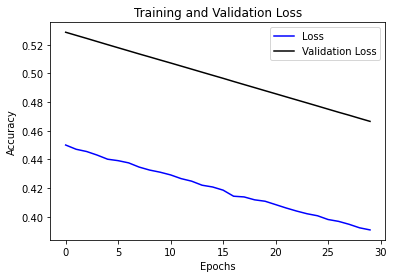

<Figure size 432x288 with 0 Axes>

In [31]:
mae=history.history['mae']
loss=history.history['loss']
val_mae=history.history['val_mae']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
#plt.plot(epochs, val_mae, 'g')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()


Comments:
We only take 100 epochs, and the loss steadily diminishes, but the predictions only roughly remember the original data. Spikes are very far from "reality". Improvements are the next step.

# Traigo la base de temperatura

After making a first essay, we will retrieve another dataset and apply different models in order to predict it evolution, treated as a time series.
It is perhaps the longest temperature serie available. You can obtain more data in its url.

In this case I use pandas, as is a common tool in data science. Note that it read the file directly from its web addres.

In [32]:
"""
import pandas as pd
def get_data_by_pandas():    
    #dataset = pd.read_csv("tdaily_cet.dat.txt",on_bad_lines='skip')
    dataset = pd.read_csv("https://climexp.knmi.nl/data/tdaily_cet.dat",on_bad_lines="skip")
    #Saco las primeras filas que joden
    dataset = dataset.iloc[10::].copy()
    #cambio el nombre de la columna
    dataset.columns =["columna"]
    temperatures = []
    for t in range(len(dataset)):
        inicio = dataset.columna.iloc[t].index(".")-2
        temperature = float(dataset.columna.iloc[t][inicio::].strip())
        temperatures.append(temperature)
    dataset["Temperatura"]=temperatures
    dataset.drop("columna", axis=1, inplace= True)
    series = np.asarray(temperatures)
    time_ = np.arange(len(temperatures),dtype= float)
    return  time_,series
    """;

The following code retrieve tha data and normalizes it.

In [33]:
"""
time, series = get_data_by_pandas()   
mean = series.mean(axis=0)
series-=mean
std = series.std(axis=0)
series/=std
split_time = 7800
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
"""

'\ntime, series = get_data_by_pandas()   \nmean = series.mean(axis=0)\nseries-=mean\nstd = series.std(axis=0)\nseries/=std\nsplit_time = 7800\ntime_train = time[:split_time]\nx_train = series[:split_time]\ntime_valid = time[split_time:]\nx_valid = series[split_time:]\nplt.figure(figsize=(10, 6))\nplot_series(time_valid, x_valid)\n'

As it is shown, the data has a center by 0, and the normalized values are between -3,2 and 3. 

###  GRU Bidirectional/ 







In [34]:
"""
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
# Experiment with this to play with accuracy. Do note that
# this is a small dataset, so a large window size may
# cause errors.
window_size = 40
batch_size = 20
shuffle_buffer_size = 20

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.1)),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)), 
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=10,  verbose=1, validation_data=valid_dataset)
""";

In [35]:
"""
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]
""";

In [36]:
"""
plt.figure(figsize=(10,6))
plot_series(time_valid[:100], x_valid[:100])
plot_series(time_valid[:100], forecast[:100])
plt.show()
""";

Please note that from the ninety thousand original values, only a hundred are plotted in order to have a good visualization of what is going on.

In this case we can see that the network succeed at grasping the general trend and pattern, even if its accuracy, mainly at spikes, is not perfect. Feel free of playing with the different parameters (number of layers, neurons per layer, learning_ratem window_size, and so on) to find a better model.

In [37]:
"""
mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(f"mae: {mae}")
""";

In [38]:
"""
mae=history.history['mae']
loss=history.history['loss']
val_mae=history.history['val_mae']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
#plt.plot(epochs, val_mae, 'g')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()
""";

## Comment: Bidirectional models with both drop out are time consuming.

#  SimpleRNN

Epoch 1/30
37/37 [==============================] - 5s 85ms/step - loss: 1.3672 - mae: 1.3672 - val_loss: 0.6034 - val_mae: 0.6034
Epoch 2/30
37/37 [==============================] - 3s 79ms/step - loss: 0.8442 - mae: 0.8442 - val_loss: 0.3821 - val_mae: 0.3821
Epoch 3/30
37/37 [==============================] - 3s 78ms/step - loss: 0.7270 - mae: 0.7270 - val_loss: 0.4031 - val_mae: 0.4031
Epoch 4/30
37/37 [==============================] - 3s 79ms/step - loss: 0.6464 - mae: 0.6464 - val_loss: 0.4583 - val_mae: 0.4583
Epoch 5/30
37/37 [==============================] - 3s 79ms/step - loss: 0.6081 - mae: 0.6081 - val_loss: 0.4650 - val_mae: 0.4650
Epoch 6/30
37/37 [==============================] - 3s 79ms/step - loss: 0.6100 - mae: 0.6100 - val_loss: 0.4780 - val_mae: 0.4780
Epoch 7/30
37/37 [==============================] - 3s 78ms/step - loss: 0.5609 - mae: 0.5609 - val_loss: 0.4691 - val_mae: 0.4691
Epoch 8/30
37/37 [==============================] - 3s 78ms/step - loss: 0.5467 - m

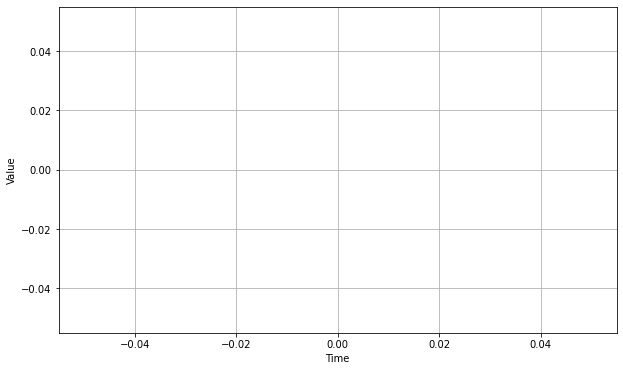

mae: 0.29162469506263733
Ajustar y evaluar este modelo demoró 1.51 minutos.


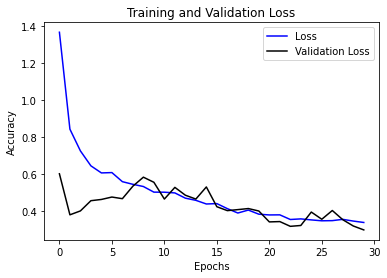

<Figure size 432x288 with 0 Axes>

##################################
With doble return_sequence epoch 10: loss: 0.5599 - mae: 0.5599 - val_loss: 0.5682 - val_mae: 0.5682


In [39]:
tf.keras.backend.clear_session()
"""
tf.random.set_seed(42)
np.random.seed(42)
# Experiment with this to play with accuracy. Do note that
# this is a small dataset, so a large window size may
# cause errors.
window_size = 40
batch_size = 20
shuffle_buffer_size = 20

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
"""
now = time.time()
model = tf.keras.models.Sequential([
  #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.SimpleRNN(100, input_shape=[None, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.5),
  tf.keras.layers.SimpleRNN(100,  dropout=0.1, recurrent_dropout=0.5, activation='relu'), #le saqué return_sequences=True,
  tf.keras.layers.Dense(1),
])

model.compile(loss='mae', optimizer=tf.keras.optimizers.RMSprop(), metrics=["mae"])
history = model.fit(dataset, epochs=30,  verbose=1,validation_data=valid_dataset)
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]
#plot_series(time, series, format="-", start=0, end=None)
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid,start = 1000, end= 1500)
plot_series(time_valid, forecast,start = 1000, end= 1500)
plt.show()
mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(f"mae: {mae}")
print (f"Ajustar y evaluar este modelo demoró {round((time.time()-now)/60,2)} minutos.")
mae=history.history['mae']
loss=history.history['loss']
val_mae=history.history['val_mae']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
#plt.plot(epochs, val_mae, 'g')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()
print ("#"*34)
print ("With doble return_sequence epoch 10: loss: 0.5599 - mae: 0.5599 - val_loss: 0.5682 - val_mae: 0.5682")

Please note the return sequence, in the recurrent layer, except the last one.

# Ahora va con simple LSTM pág 208

Epoch 1/30
37/37 [==============================] - 13s 248ms/step - loss: 1.5596 - mae: 1.5596 - val_loss: 0.8175 - val_mae: 0.8175
Epoch 2/30
37/37 [==============================] - 9s 237ms/step - loss: 0.6567 - mae: 0.6567 - val_loss: 0.6097 - val_mae: 0.6097
Epoch 3/30
37/37 [==============================] - 9s 236ms/step - loss: 0.4621 - mae: 0.4621 - val_loss: 0.2910 - val_mae: 0.2910
Epoch 4/30
37/37 [==============================] - 9s 237ms/step - loss: 0.3557 - mae: 0.3557 - val_loss: 0.2529 - val_mae: 0.2529
Epoch 5/30
37/37 [==============================] - 9s 238ms/step - loss: 0.3078 - mae: 0.3078 - val_loss: 0.1841 - val_mae: 0.1841
Epoch 6/30
37/37 [==============================] - 9s 238ms/step - loss: 0.2922 - mae: 0.2922 - val_loss: 0.2463 - val_mae: 0.2463
Epoch 7/30
37/37 [==============================] - 9s 238ms/step - loss: 0.2808 - mae: 0.2808 - val_loss: 0.3339 - val_mae: 0.3339
Epoch 8/30
37/37 [==============================] - 9s 240ms/step - loss: 0

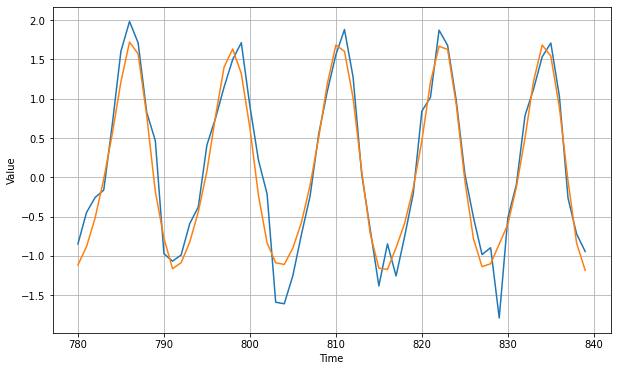

mae: 0.22745415568351746
Ajustar y evaluar este modelo demoró 4.47 minutos.


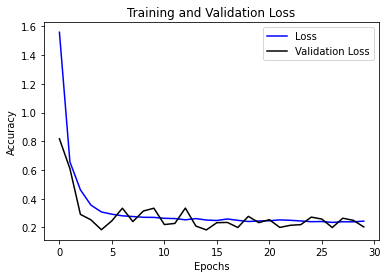

<Figure size 432x288 with 0 Axes>

In [40]:
tf.keras.backend.clear_session()
"""
tf.random.set_seed(42)
np.random.seed(42)
# Experiment with this to play with accuracy. 
window_size = 40
batch_size = 20
shuffle_buffer_size = 20

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
"""
now = time.time()
model = tf.keras.models.Sequential([
  #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.LSTM(100, input_shape=[None, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.5),
  tf.keras.layers.LSTM(100,  dropout=0.1, recurrent_dropout=0.5, activation='relu'), #le saqué return_sequences=True
  tf.keras.layers.Dense(1),
])

model.compile(loss='mae', optimizer=tf.keras.optimizers.RMSprop(), metrics=["mae"])
history = model.fit(dataset, epochs=30,  verbose=1,validation_data=valid_dataset)
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()
mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(f"mae: {mae}")
print (f"Ajustar y evaluar este modelo demoró {round((time.time()-now)/60,2)} minutos.")
mae=history.history['mae']
loss=history.history['loss']
val_mae=history.history['val_mae']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
#plt.plot(epochs, val_mae, 'g')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

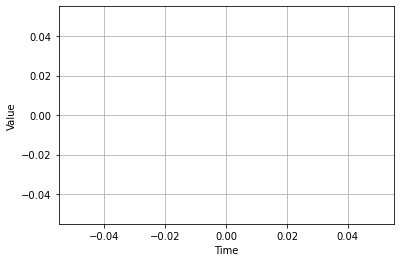

In [41]:
plot_series(time_valid, x_valid,start = 1000, end= 1500)
plot_series(time_valid, forecast,start = 1000, end= 1500)

# Aquí va con simple GRU

Epoch 1/30
37/37 [==============================] - 12s 232ms/step - loss: 0.3686 - mse: 0.2248 - val_loss: 0.2651 - val_mse: 0.1120
Epoch 2/30
37/37 [==============================] - 9s 243ms/step - loss: 0.2988 - mse: 0.1425 - val_loss: 0.2777 - val_mse: 0.1206
Epoch 3/30
37/37 [==============================] - 8s 219ms/step - loss: 0.2852 - mse: 0.1313 - val_loss: 0.2461 - val_mse: 0.0933
Epoch 4/30
37/37 [==============================] - 8s 217ms/step - loss: 0.2884 - mse: 0.1345 - val_loss: 0.2501 - val_mse: 0.1015
Epoch 5/30
37/37 [==============================] - 8s 217ms/step - loss: 0.2828 - mse: 0.1280 - val_loss: 0.2557 - val_mse: 0.1225
Epoch 6/30
37/37 [==============================] - 8s 217ms/step - loss: 0.2697 - mse: 0.1187 - val_loss: 0.2681 - val_mse: 0.1268
Epoch 7/30
37/37 [==============================] - 8s 218ms/step - loss: 0.2787 - mse: 0.1279 - val_loss: 0.2188 - val_mse: 0.0856
Epoch 8/30
37/37 [==============================] - 8s 222ms/step - loss: 0

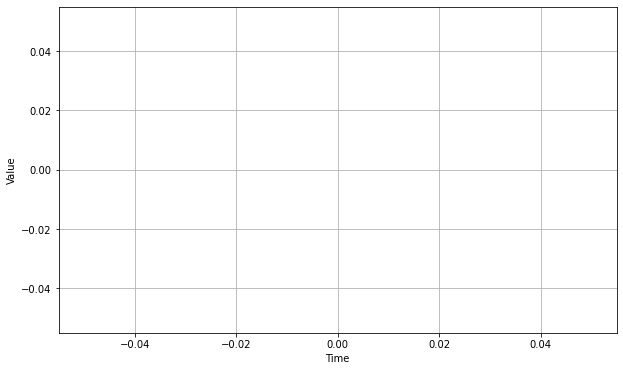

mae: 0.23359079658985138
Ajustar y evaluar este modelo demoró 4.19 minutos.


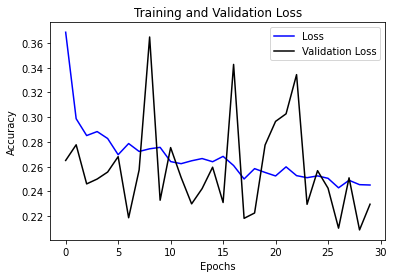

<Figure size 432x288 with 0 Axes>

In [43]:

tf.keras.backend.clear_session()
"""
tf.random.set_seed(42)
np.random.seed(42)
# Experiment with this to play with accuracy. Do note that
# this is a small dataset, so a large window size may
# cause errors.
window_size = 40
batch_size = 20
shuffle_buffer_size = 20

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
"""
now = time.time()
model = tf.keras.models.Sequential([
  #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.5),#,unroll=True),
  tf.keras.layers.GRU(100,  dropout=0.1, recurrent_dropout=0.5),#, unroll=True), #le saqué return_sequences=True,
  tf.keras.layers.Dense(1),
])

model.compile(loss='mae', optimizer=tf.keras.optimizers.RMSprop(), metrics=["mse"])
history = model.fit(dataset, epochs=30,  verbose=1,validation_data=valid_dataset)
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid,start = 1000, end= 1500)
plot_series(time_valid, forecast,start = 1000, end= 1500)
plt.show()
mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(f"mae: {mae}")
print (f"Ajustar y evaluar este modelo demoró {round((time.time()-now)/60,2)} minutos.")
#mae=history.history['mae']
loss=history.history['loss']
#val_mae=history.history['val_mae']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
#plt.plot(epochs, val_mae, 'g')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()
"https://stackoverflow.com/questions/68844792/lstm-will-not-use-cudnn-kernels-since-it-doesnt-meet-the-criteria-it-will-use";

# Con una pequeña ff network

Epoch 1/30
37/37 [==============================] - 1s 8ms/step - loss: 0.9516 - mae: 0.9516 - val_loss: 0.9731 - val_mae: 0.9731
Epoch 2/30
37/37 [==============================] - 0s 4ms/step - loss: 0.9512 - mae: 0.9512 - val_loss: 0.9730 - val_mae: 0.9730
Epoch 3/30
37/37 [==============================] - 0s 4ms/step - loss: 0.9508 - mae: 0.9508 - val_loss: 0.9729 - val_mae: 0.9729
Epoch 4/30
37/37 [==============================] - 0s 4ms/step - loss: 0.9503 - mae: 0.9503 - val_loss: 0.9727 - val_mae: 0.9727
Epoch 5/30
37/37 [==============================] - 0s 4ms/step - loss: 0.9499 - mae: 0.9499 - val_loss: 0.9726 - val_mae: 0.9726
Epoch 6/30
37/37 [==============================] - 0s 4ms/step - loss: 0.9495 - mae: 0.9495 - val_loss: 0.9725 - val_mae: 0.9725
Epoch 7/30
37/37 [==============================] - 0s 4ms/step - loss: 0.9490 - mae: 0.9490 - val_loss: 0.9724 - val_mae: 0.9724
Epoch 8/30
37/37 [==============================] - 0s 4ms/step - loss: 0.9486 - mae: 0.94

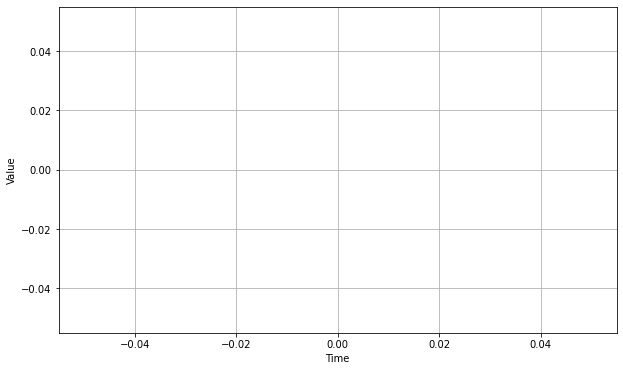

mae: [0.9428342  0.9348639  0.9995594  1.0702057  1.0560502  0.9965598
 0.9978096  0.93680876 0.9348639  0.9369894  0.94314766 0.94711345
 0.94156206 0.9348639  0.9589104  1.022181   1.0953044  0.9812014
 0.9565357  0.9395563  0.9366576  0.9429817  0.94631904 0.9484964
 0.94163585 0.9357264  0.95678574 1.0720387  0.99006045 1.0280138
 0.95216113 0.9348639  0.93719226 0.94019765 0.9481645  0.94808143
 0.94300014 0.9360306  0.9709539  0.9784934  0.9812014  0.9504114
 0.94088846 0.9368921  0.93728447 0.9460793  0.9513449  0.947473
 0.9387042  0.9352932  0.9960598  1.0083085  0.99830955 0.95966035
 0.9460527  0.9348639  0.9379851  0.9417649  0.9450837  0.94750065]
Ajustar y evaluar este modelo demoró 0.1 minutos.


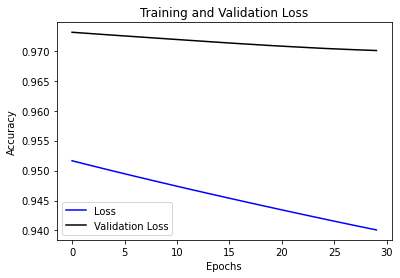

<Figure size 432x288 with 0 Axes>

In [44]:
"""
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
# Experiment with this to play with accuracy. Do note that
# this is a small dataset, so a large window size may
# cause errors.
window_size = 40
batch_size = 20
shuffle_buffer_size = 20

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
"""
now = time.time()
model = tf.keras.models.Sequential([
  #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
  tf.keras.layers.Dense(25, input_shape=[None, 1]),
  tf.keras.layers.Dense(12,   activation='relu'), #le saqué return_sequences=True,
  tf.keras.layers.Dense(1),])

model.compile(loss='mae', optimizer=tf.keras.optimizers.SGD(learning_rate = 5e-5), metrics=["mae"])
history = model.fit(dataset, epochs=30,  verbose=1,validation_data=valid_dataset)
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid,start = 1000, end= 1500)
plot_series(time_valid, forecast,start = 1000, end= 1500)
plt.show()
mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(f"mae: {mae}")
print (f"Ajustar y evaluar este modelo demoró {round((time.time()-now)/60,2)} minutos.")
mae=history.history['mae']
loss=history.history['loss']
#val_mae=history.history['val_mae']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
#plt.plot(epochs, val_mae, 'g')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

In [45]:
print (f"Demoró {round((time.time()-now_i)/60,2)} minutos ejecutar este cuaderno.")

Demoró 24.79 minutos ejecutar este cuaderno.


Bidirectional GRU

mae: 0.8474304

Ajustar y evaluar este modelo demoró 8.07 minutos.

SimpleRNN

mae: 0.29162469506263733

Ajustar y evaluar este modelo demoró 1.51 minutos.

simple LSTM pág 208

mae: 0.22745415568351746

Ajustar y evaluar este modelo demoró 4.47 minutos.